In this notebook I'm practicing feature selection with lasso, and ridge regression.  

I've been anxious to test these techniques on a new data set so here it goes.  

I've also been told using Lasso to show which features in your data area most important can be very effective for a number of work situations.  I'll visualize this toward the end where one can clearly see the best variable to predict price.  

We'll start and use Sci-kit learn.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)


kc = pd.read_csv("../input/kc_house_data.csv")
print(kc.head())
print(kc.shape)
print(kc.dtypes)

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0           0     0     ...          7        1180   
1      7242     2.0           0     0     ...          7        2170   
2     10000     1.0           0     0     ...          6         770   
3      5000     1.0           0     0     ...          7        1050   
4      8080     1.0           0     0     ...          8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955 

In [2]:
# Dropping a few columns.  Waterfront and view are binary. 
kc = kc.drop(['id', 'date', 'view', 'waterfront'],axis=1)

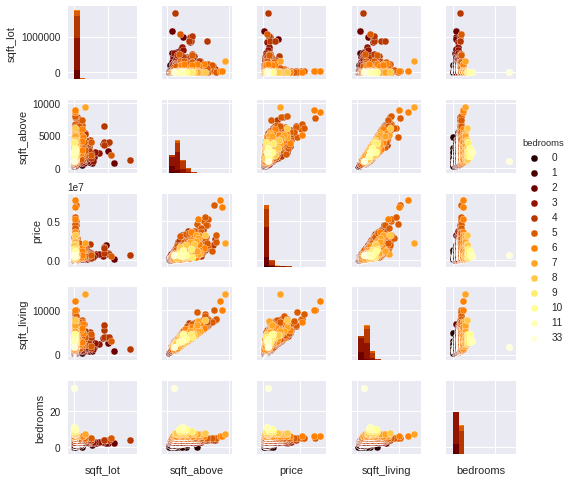

In [3]:
p = sns.pairplot(kc[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='afmhot',size=1.4)
p.set(xticklabels=[])

In [4]:
# extract our target variable -- House prices -- into an array 
y = kc.price.values
y # is an array with the price variable 

# Drop price from the house dataframe 
kc = kc.drop(['price'], axis=1)

# Create a matrix from the remaining data
X = kc.as_matrix()

# Store the column/feature names into a list "colnames"
colnames = kc.columns

The LASSO (Least Absolute Shrinkage and Selection Operator) is a regression method that involves penalizing the absolute size of the regression coefficients.

By penalizing or constraining the sum of the absolute values of the estimates you make some of your coefficients zero. The larger the penalty applied, the further estimates are shrunk towards zero.  This is convenient when we want some automatic feature/variable selection, or when dealing with highly correlated predictors, where standard regression will usually have regression coefficients that are too large.  

In [5]:
# create a lasso regressor
lasso = Lasso(alpha=0.2, normalize=True)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

[ -4.60371681e+04   4.27861001e+04   2.09910162e+02   1.55917506e-01
   1.10125833e+04   2.91820514e+04   1.01162856e+05  -2.23999188e+01
  -3.02780899e+01  -2.82963779e+03   3.48449523e+01  -4.76908000e+02
   5.55627700e+05  -2.51484241e+05   4.00319113e+01  -3.23987600e-01]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


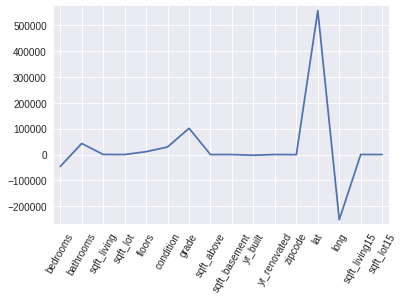

In [6]:
# Plot the coefficients
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=60) 
plt.margins(0.02)
plt.show()

This would be a great chart to show your boss or someone that's not very familiar with statistics.  It clearly shows that latitude is the most important variable terms of predicting price.  What's that real estate phrase that comes to mind here...."Location, location, location."

Now below, we will perform cross-validation on the data set and get our scores.  This might be more appropriate if we had a test/train set and were predicting.  However, having the R square gives us some context and helps going into the next cell where we are looking at how alpha changes our R square.  

In [7]:
# Import the necessary module
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

# find the mean of our cv scores here
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 0.64113769  0.65607482  0.6615889   0.67507893  0.65552482]
Average 5-Fold CV Score: 0.6578810345485424


Below we'll run a ridge regression and see how score varies with different alphas.  This will show how picking a different alpha score changes the R2.  

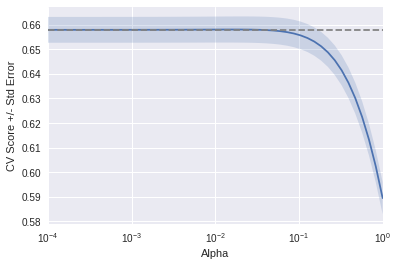

In [8]:
from sklearn.linear_model import Ridge

# Create an array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Use this function to create a plot    
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

# Display the plot
display_plot(ridge_scores, ridge_scores_std)